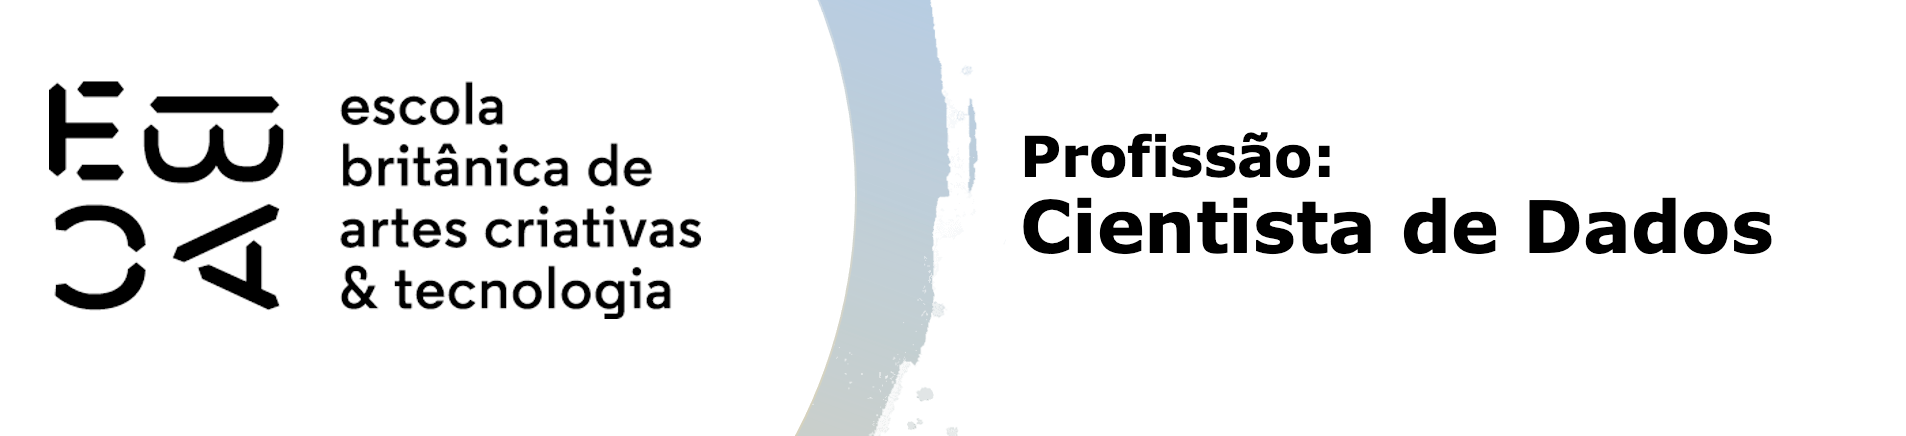

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import t
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve

import warnings

In [3]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    tulo_evento = tab.columns[0]
    tulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[tulo_evento]/tab.loc['total',tulo_evento]
    tab['ep'] = tab[tulo_evento]/tab.loc['total',tulo_evento]
    
    tab['pct_nao_evento'] = tab[tulo_nao_evento]/tab.loc['total',tulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [4]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=8)
    
    ax[1] = biv.cont.plot.bar()
    return biv

In [5]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

In [6]:
df = pd.read_feather('credit_scoring.ftr')
df.head(2)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [8]:
' + '.join(list(df.columns))

'data_ref + index + sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau'

In [9]:
df.data_ref.value_counts()

2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64

In [10]:
# Separando base de treino e base de teste

df.set_index('data_ref', inplace = True)

df_train = df['2015-01-01':'2015-12-01']
df_test = df['2016-01-01':]

In [11]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [12]:
df_train['Mes'] = df_train['data_ref'].dt.month
warnings.filterwarnings('ignore')

C:\Users\Lucas\AppData\Local\Temp\ipykernel_7552\1797461032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Mes'] = df_train['data_ref'].dt.month


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

Text(0.5, 1.0, 'Número de linhas para cada mês da base de treino')

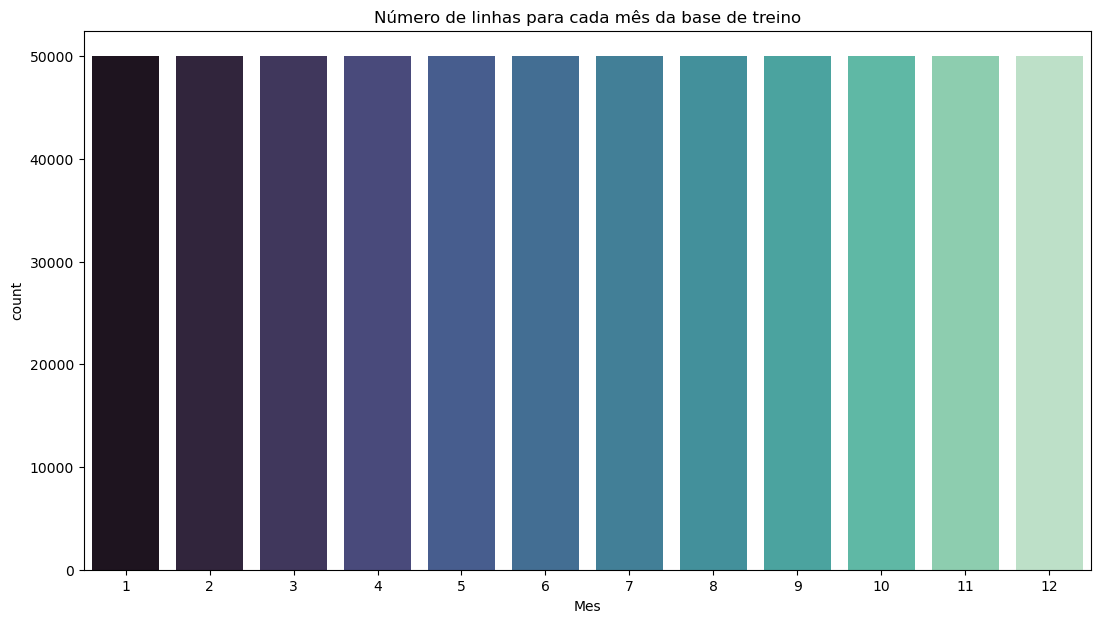

In [13]:
fig, ax = plt.subplots(figsize=(13,7))
sns.countplot(data=df_train, x='Mes', palette='mako', ax=ax)
ax.set_title('Número de linhas para cada mês da base de treino')

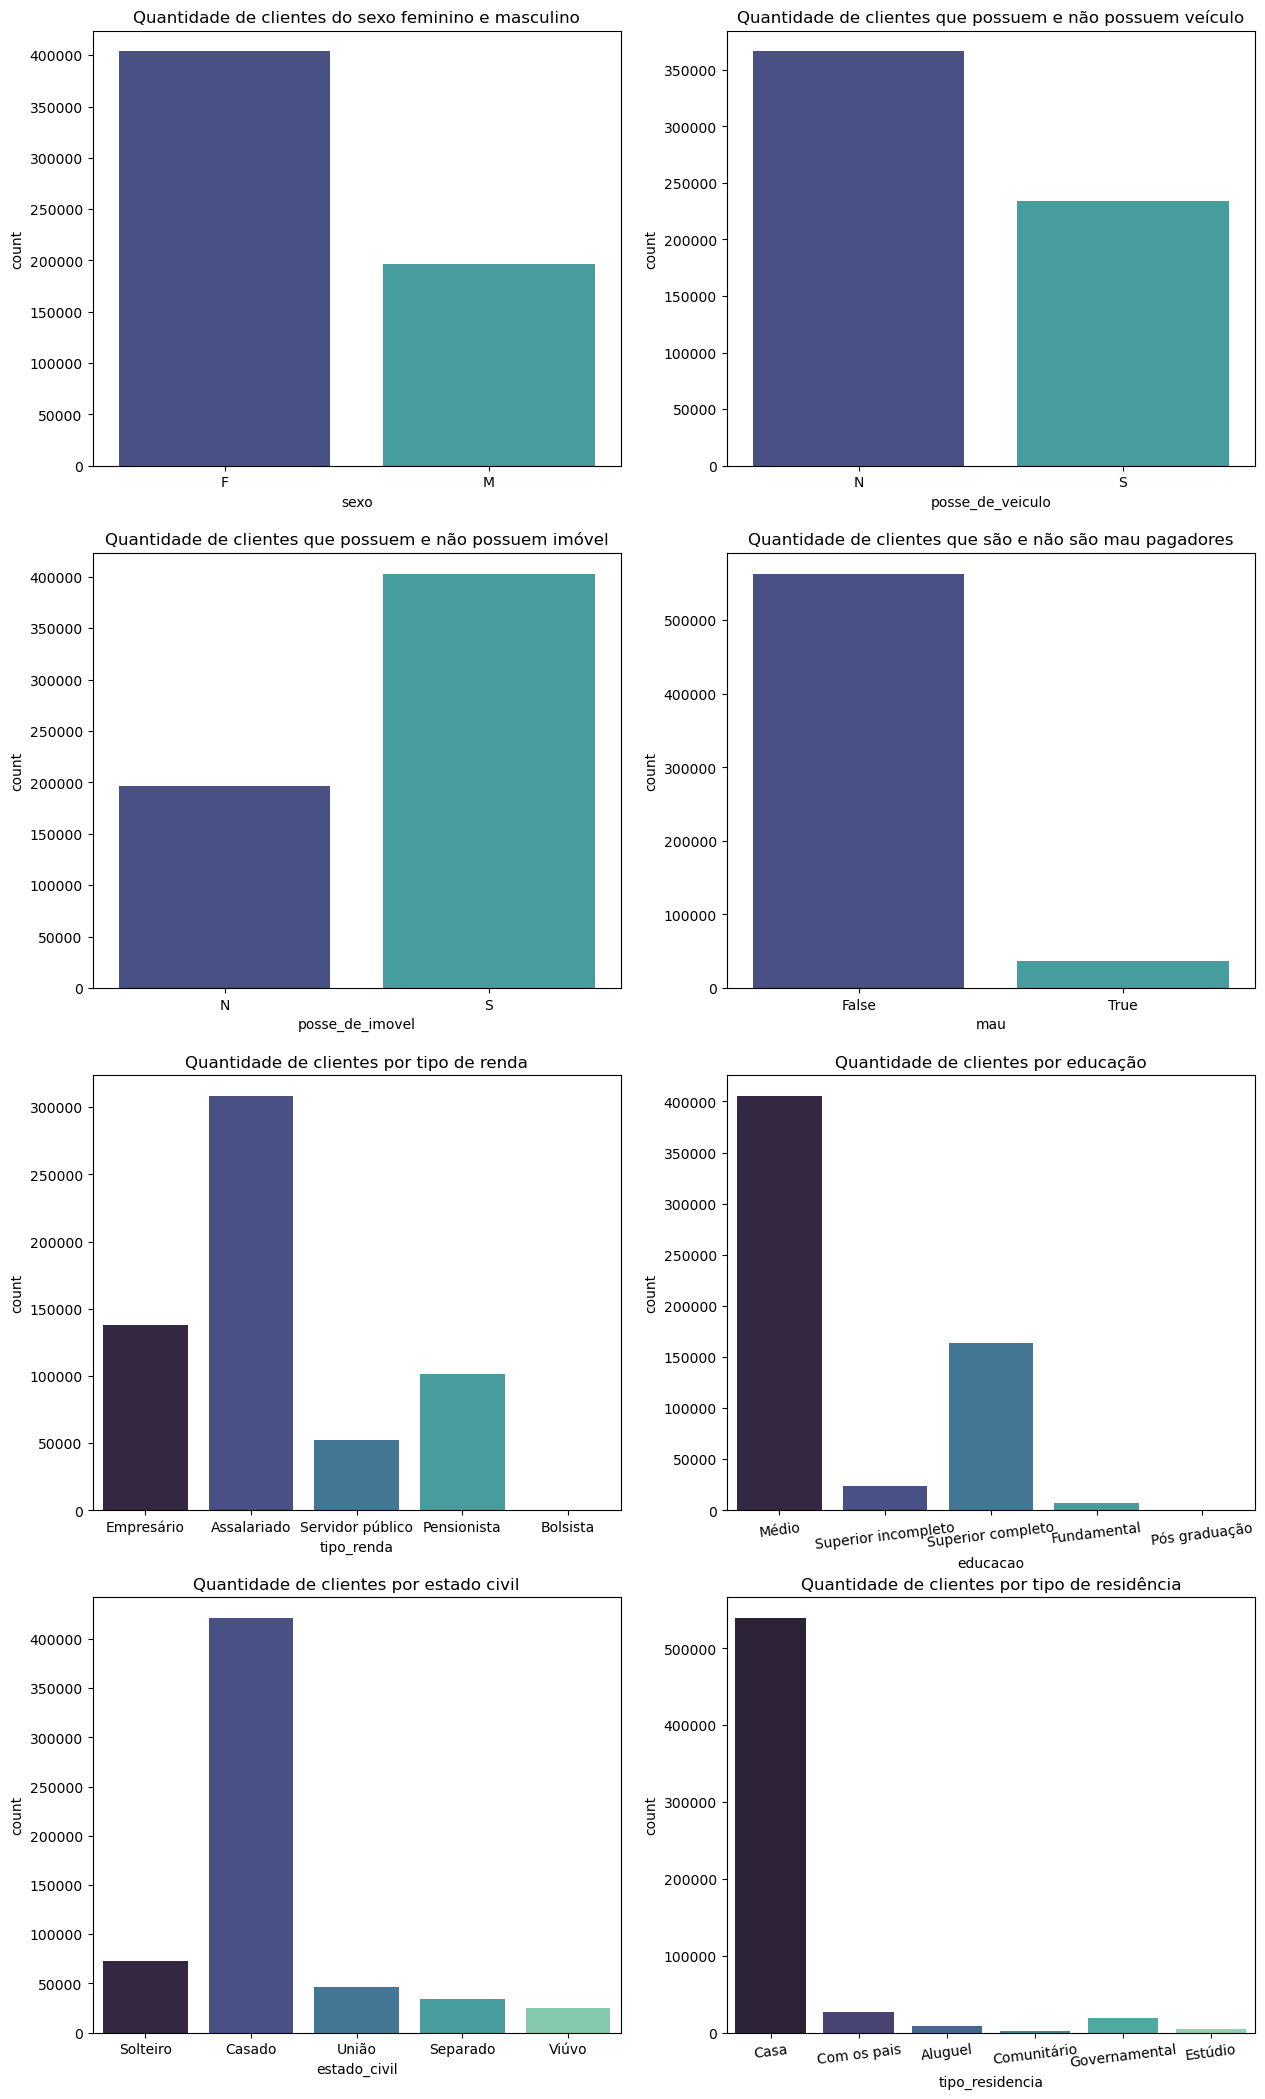

In [14]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,26))

sns.countplot(data=df_train, x='sexo', palette='mako', ax=ax[0,0])
ax[0,0].set_title('Quantidade de clientes do sexo feminino e masculino')

sns.countplot(data=df_train, x='posse_de_veiculo', palette='mako', ax=ax[0,1])
ax[0,1].set_title('Quantidade de clientes que possuem e não possuem veículo')

sns.countplot(data=df_train, x='posse_de_imovel', palette='mako', ax=ax[1,0])
ax[1,0].set_title('Quantidade de clientes que possuem e não possuem imóvel')

sns.countplot(data=df_train, x='mau', palette='mako', ax=ax[1,1])
ax[1,1].set_title('Quantidade de clientes que são e não são mau pagadores')

sns.countplot(data=df_train, x='tipo_renda', palette='mako', ax=ax[2,0])
ax[2,0].set_title('Quantidade de clientes por tipo de renda')

sns.countplot(data=df_train, x='educacao', palette='mako', ax=ax[2,1])
ax[2,1].set_title('Quantidade de clientes por educação')
for tick in ax[2,1].get_xticklabels():
    tick.set_rotation(7)

sns.countplot(data=df_train, x='estado_civil', palette='mako', ax=ax[3,0])
ax[3,0].set_title('Quantidade de clientes por estado civil')

sns.countplot(data=df_train, x='tipo_residencia', palette='mako', ax=ax[3,1])
ax[3,1].set_title('Quantidade de clientes por tipo de residência')
for tick in ax[3,1].get_xticklabels():
    tick.set_rotation(7)

Text(0.5, 1.0, 'Quantidade de clientes por renda')

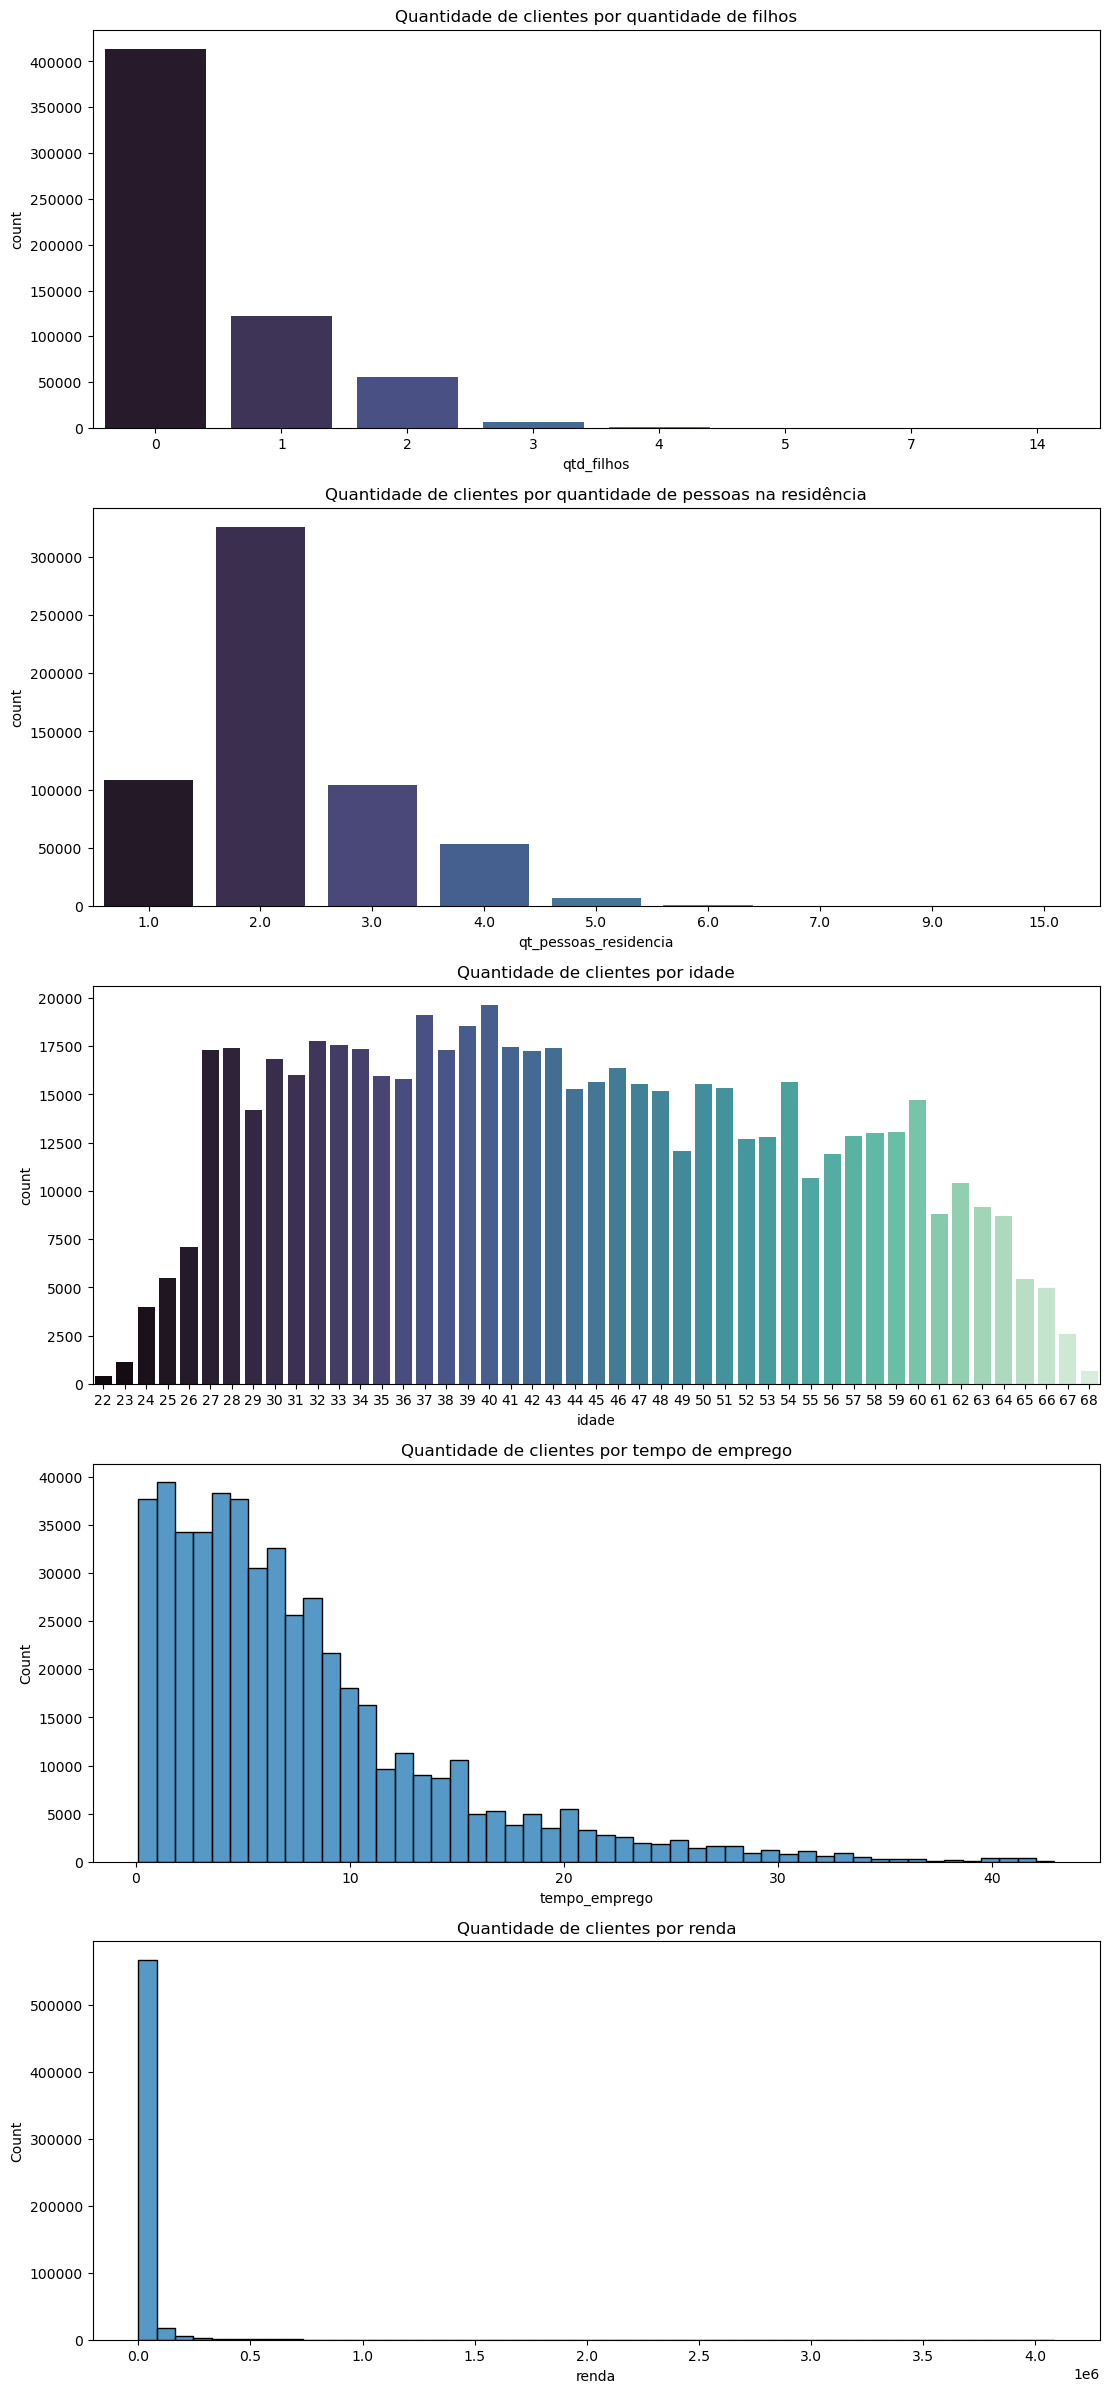

In [15]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(13,30))

sns.countplot(data=df_train, x='qtd_filhos', palette='mako', ax=ax[0])
ax[0].set_title('Quantidade de clientes por quantidade de filhos')

sns.countplot(data=df_train, x='qt_pessoas_residencia', palette='mako', ax=ax[1])
ax[1].set_title('Quantidade de clientes por quantidade de pessoas na residência')

sns.countplot(data=df_train, x='idade', palette='mako', ax=ax[2])
ax[2].set_title('Quantidade de clientes por idade')

sns.histplot(data=df_train, x='tempo_emprego', palette='dark', bins=50, ax=ax[3])
ax[3].set_title('Quantidade de clientes por tempo de emprego')

sns.histplot(data=df_train, x='renda', palette='dark', bins=50, ax=ax[4])
ax[4].set_title('Quantidade de clientes por renda')

Text(0.5, 1.0, 'Quantidade de clientes por renda menor que 50000 reais')

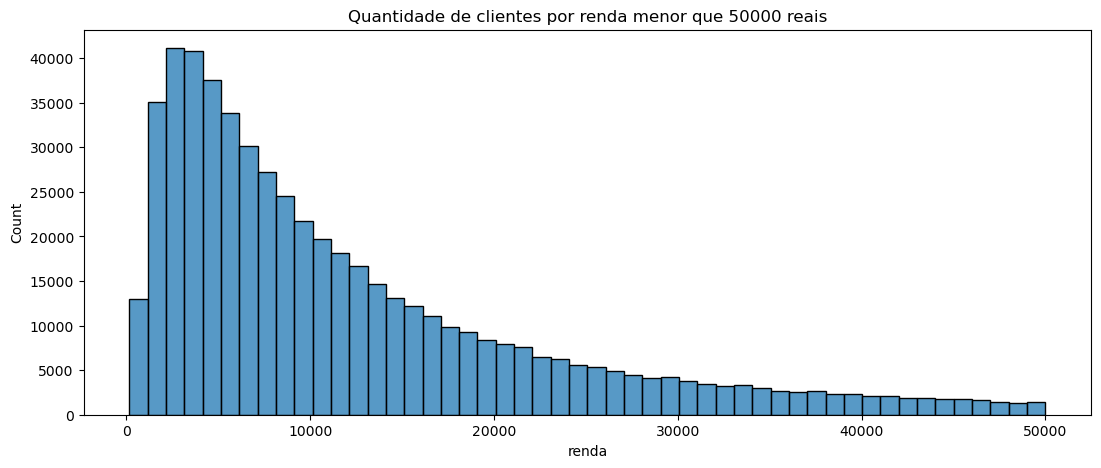

In [16]:
fig, ax = plt.subplots(figsize=(13,5))

sns.histplot(data=df_train[df_train.renda<50000], x='renda', palette='dark', bins=50, ax=ax)
ax.set_title('Quantidade de clientes por renda menor que 50000 reais')

Text(0.5, 1.0, 'Quantidade de clientes por renda maior que 500000 reais')

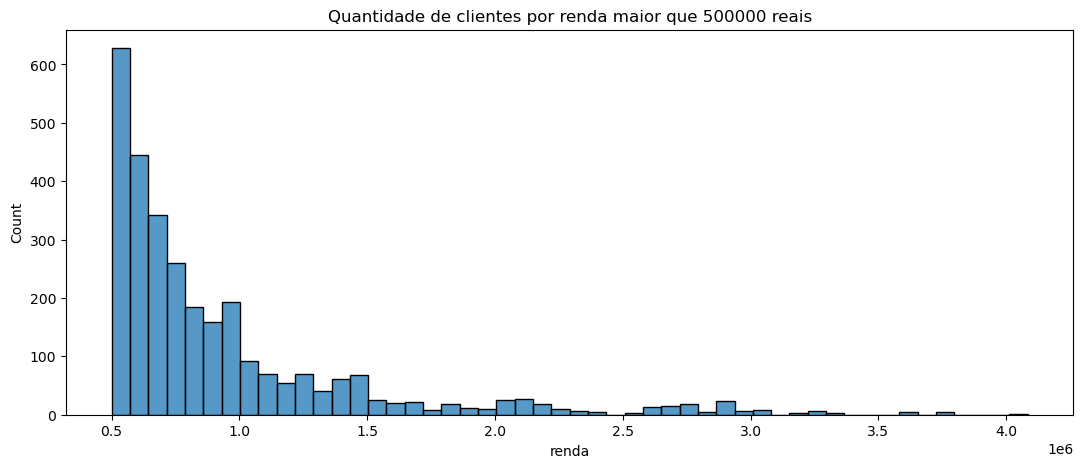

In [17]:
fig, ax = plt.subplots(figsize=(13,5))

sns.histplot(data=df_train[df_train.renda>500000], x='renda', palette='dark', bins=50, ax=ax)
ax.set_title('Quantidade de clientes por renda maior que 500000 reais')

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

Text(0, 0.5, 'Proporção de inadimplentes')

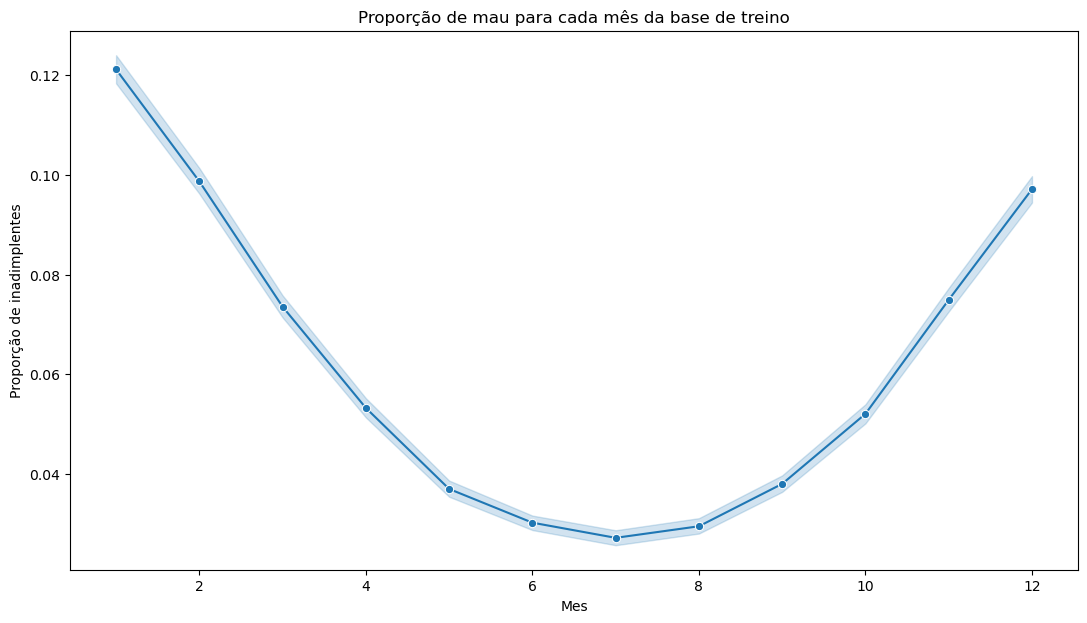

In [18]:
fig, ax = plt.subplots(figsize=(13,7))
sns.lineplot(data=df_train, x='Mes', y='mau', palette='mako', ax=ax, marker='o')
ax.set_title('Proporção de mau para cada mês da base de treino')
ax.set_ylabel("Proporção de inadimplentes")

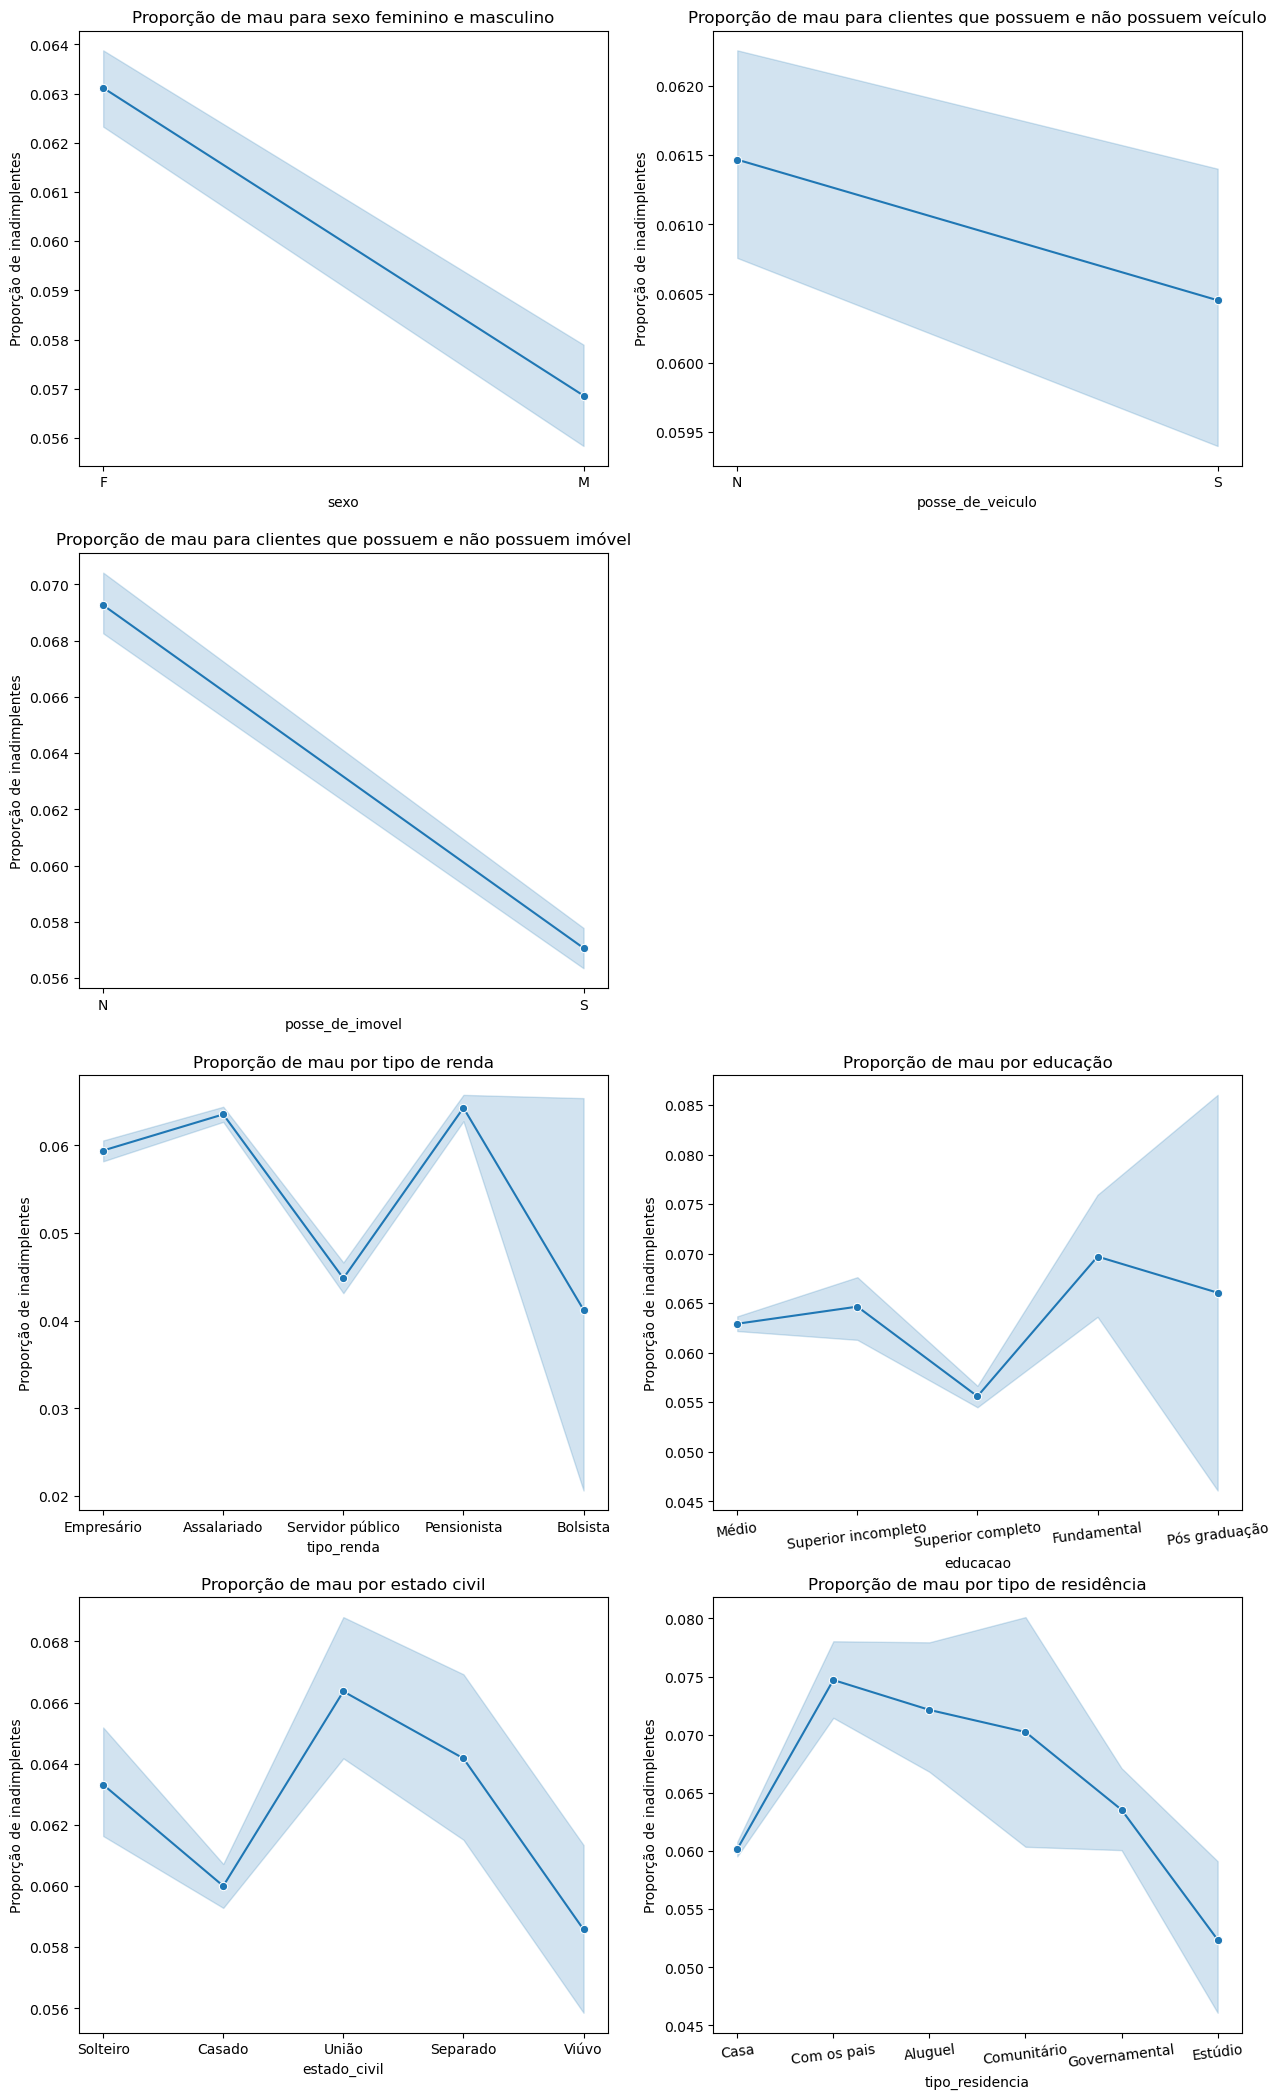

In [19]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,26))

sns.lineplot(data=df_train, x='sexo', y='mau', palette='mako', ax=ax[0,0], marker='o')
ax[0,0].set_title('Proporção de mau para sexo feminino e masculino')
ax[0,0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='posse_de_veiculo', y='mau', palette='mako', ax=ax[0,1], marker='o')
ax[0,1].set_title('Proporção de mau para clientes que possuem e não possuem veículo')
ax[0,1].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='posse_de_imovel', y='mau', palette='mako', ax=ax[1,0], marker='o')
ax[1,0].set_title('Proporção de mau para clientes que possuem e não possuem imóvel')
ax[1,0].set_ylabel("Proporção de inadimplentes")

ax[1,1].axis('off')

sns.lineplot(data=df_train, x='tipo_renda', y='mau', palette='mako', ax=ax[2,0], marker='o')
ax[2,0].set_title('Proporção de mau por tipo de renda')
ax[2,0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='educacao', y='mau', palette='mako', ax=ax[2,1], marker='o')
ax[2,1].set_title('Proporção de mau por educação')
ax[2,1].set_ylabel("Proporção de inadimplentes")
for tick in ax[2,1].get_xticklabels():
    tick.set_rotation(7)

sns.lineplot(data=df_train, x='estado_civil', y='mau', palette='mako', ax=ax[3,0], marker='o')
ax[3,0].set_title('Proporção de mau por estado civil')
ax[3,0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='tipo_residencia', y='mau', palette='mako', ax=ax[3,1], marker='o')
ax[3,1].set_title('Proporção de mau por tipo de residência')
ax[3,1].set_ylabel("Proporção de inadimplentes")
for tick in ax[3,1].get_xticklabels():
    tick.set_rotation(7)

Text(0, 0.5, 'Proporção de inadimplentes')

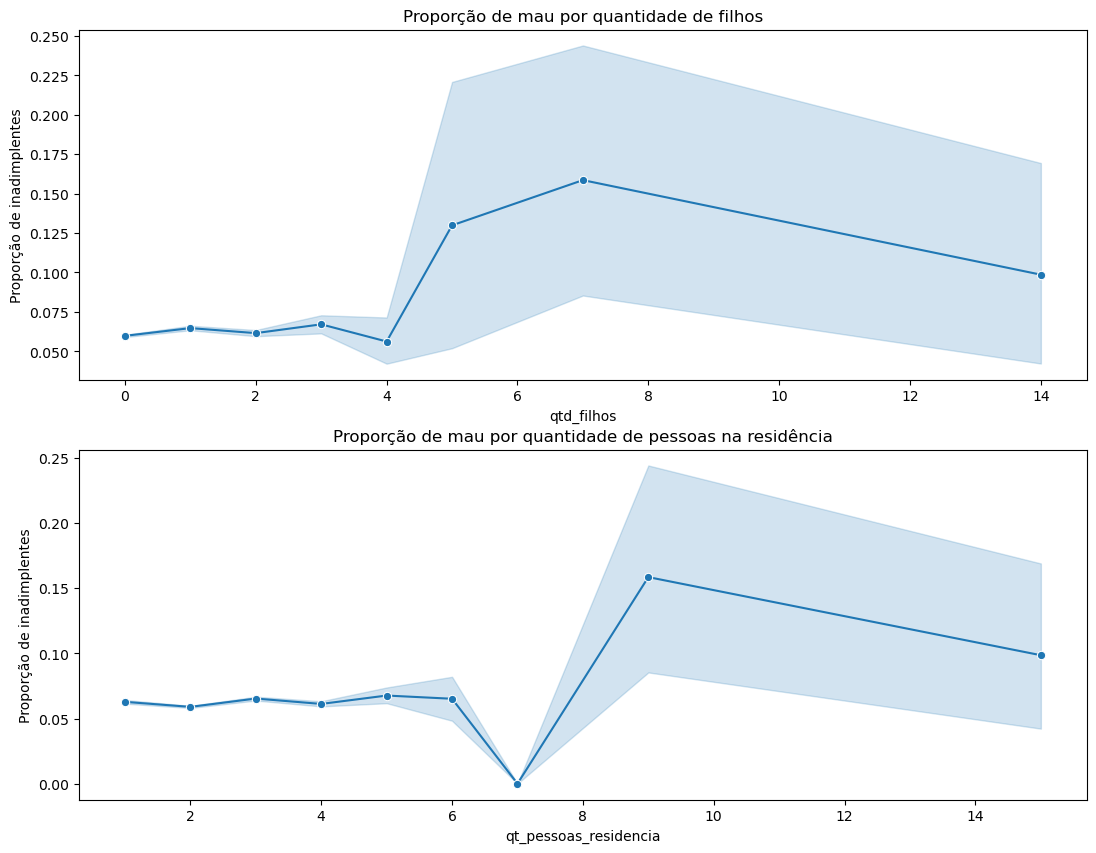

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13,10))

sns.lineplot(data=df_train, x='qtd_filhos', y='mau', palette='mako', ax=ax[0], marker='o')
ax[0].set_title('Proporção de mau por quantidade de filhos')
ax[0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='qt_pessoas_residencia', y='mau', palette='mako', ax=ax[1], marker='o')
ax[1].set_title('Proporção de mau por quantidade de pessoas na residência')
ax[1].set_ylabel("Proporção de inadimplentes")

Text(0.5, 1.0, 'Proporção de mau para intervalos de idade')

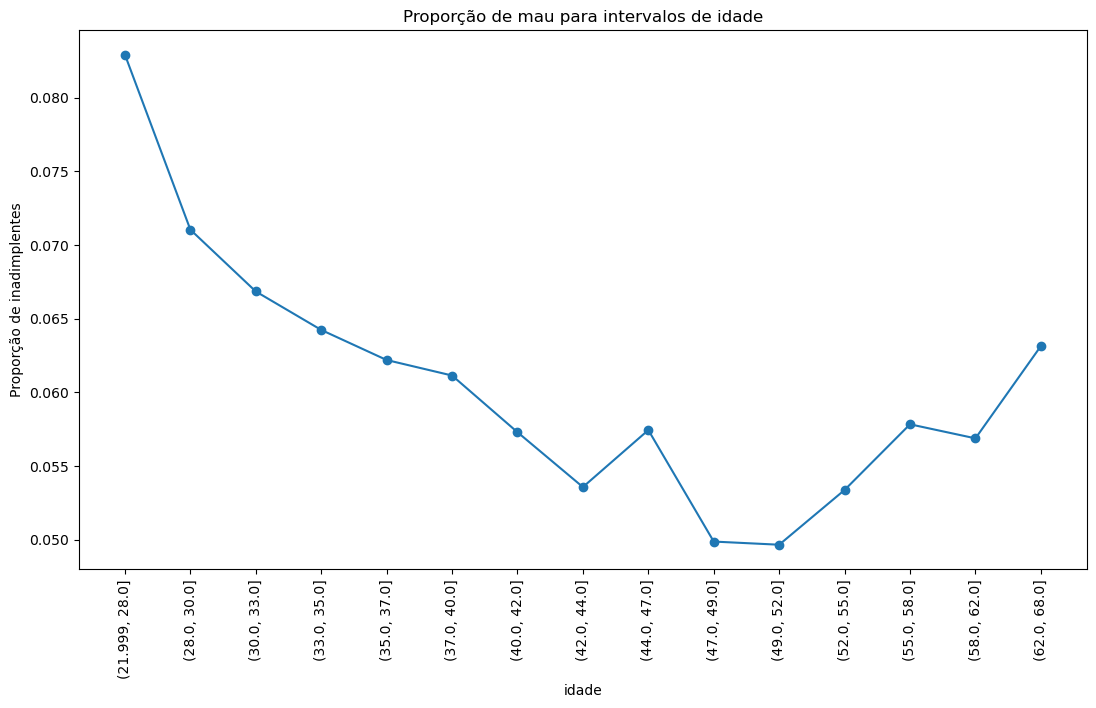

In [21]:
fig, ax = plt.subplots(figsize=(13,7))

cat_1, bins = pd.qcut(df_train['idade'], 15, retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)
ax.set_title('Proporção de mau para intervalos de idade')

Text(0.5, 1.0, 'Proporção de mau para intervalos de tempo de emprego')

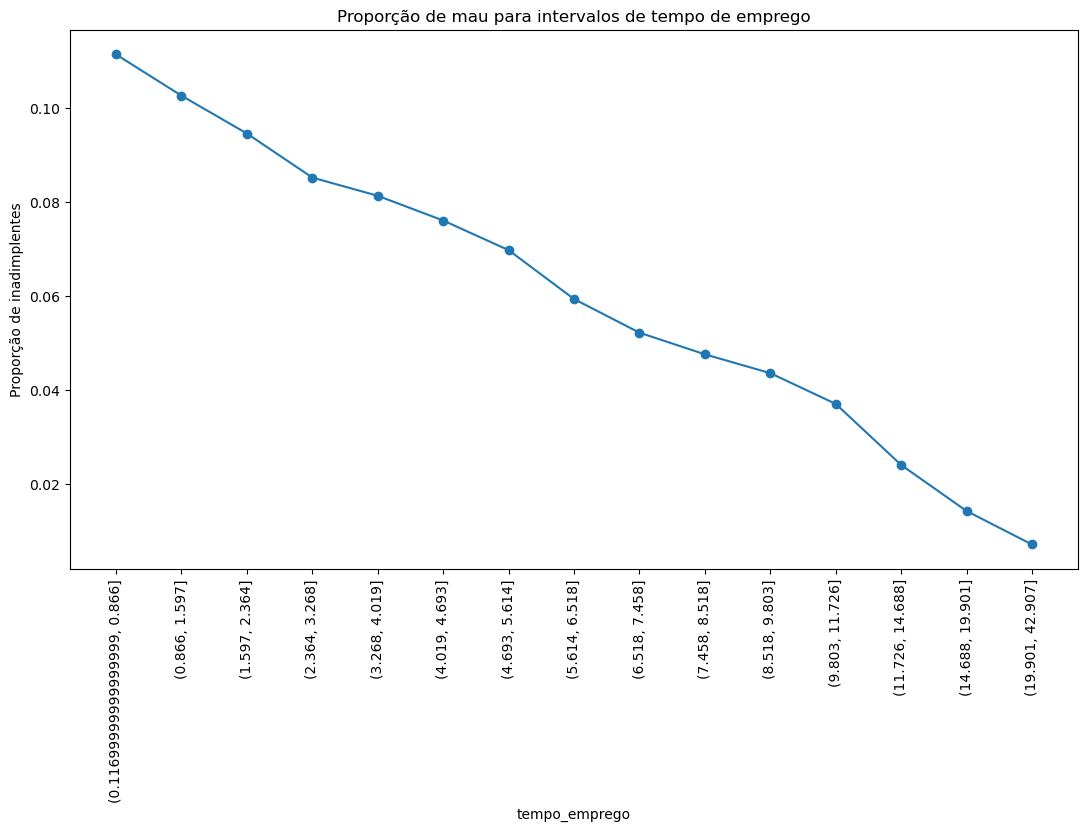

In [22]:
fig, ax = plt.subplots(figsize=(13,7))

cat_1, bins = pd.qcut(df_train['tempo_emprego'], 15, retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)
ax.set_title('Proporção de mau para intervalos de tempo de emprego')

Text(0.5, 1.0, 'Proporção de mau para intervalos de renda')

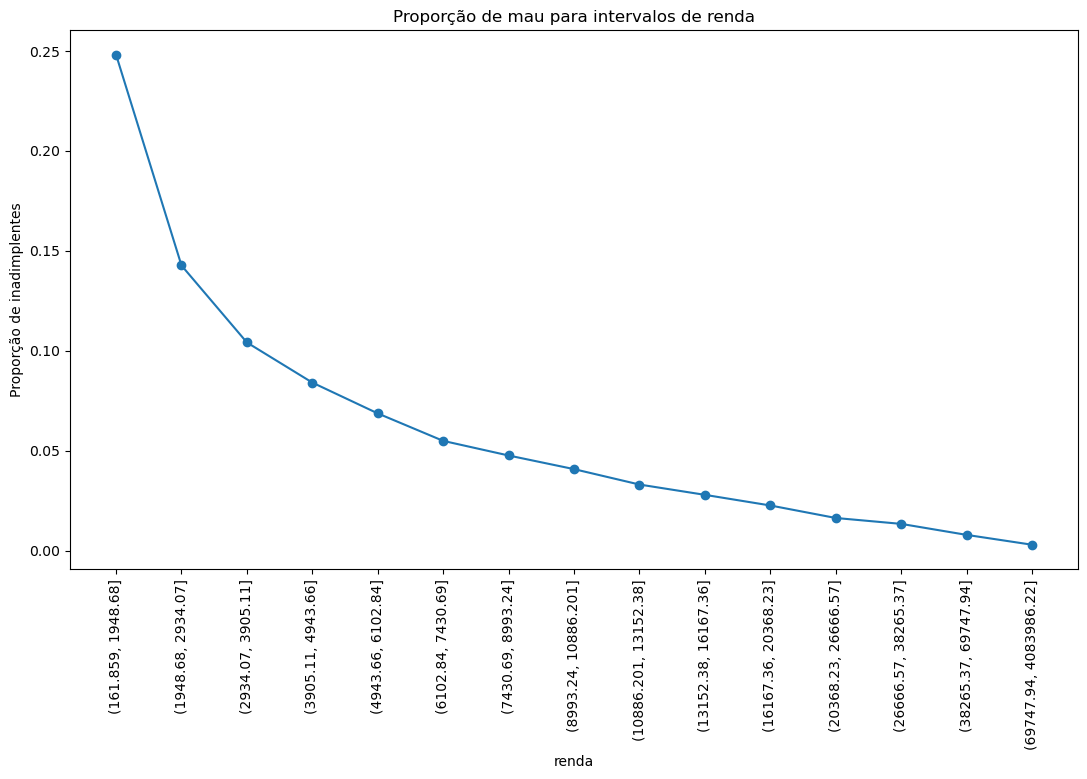

In [23]:
fig, ax = plt.subplots(figsize=(13,7))

cat_1, bins = pd.qcut(df_train['renda'], 15, retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)
ax.set_title('Proporção de mau para intervalos de renda')

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [24]:
df_train['mau'] = df_train.mau.astype('int64')
df_train.drop(columns = ['data_ref', 'index', 'Mes'], inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          499125 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 59.5+ MB


In [25]:
# Substituindo valores missing pela média

df_train['tempo_emprego'].fillna(value=df_train['tempo_emprego'].mean(), inplace=True)

In [26]:
metadados = pd.DataFrame(df_train.dtypes, columns=['dtype'])
metadados['nmissing'] = df_train.isna().sum()
metadados['valores_unicos'] = df_train.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel
tempo_emprego,float64,0,3005,covariavel


In [27]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>10):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_train[var],5,duplicates='drop'), df_train.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df_train[var], df_train.mau)
    
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0,2,covariavel,0.002665
posse_de_veiculo,object,0,2,covariavel,0.000075
posse_de_imovel,object,0,2,covariavel,0.009690
qtd_filhos,int64,0,8,covariavel,0.001689
tipo_renda,object,0,5,covariavel,0.009718
educacao,object,0,5,covariavel,0.003690
estado_civil,object,0,5,covariavel,0.001305
tipo_residencia,object,0,6,covariavel,0.003330
idade,int64,0,47,covariavel,0.018434
tempo_emprego,float64,0,3005,covariavel,0.283956


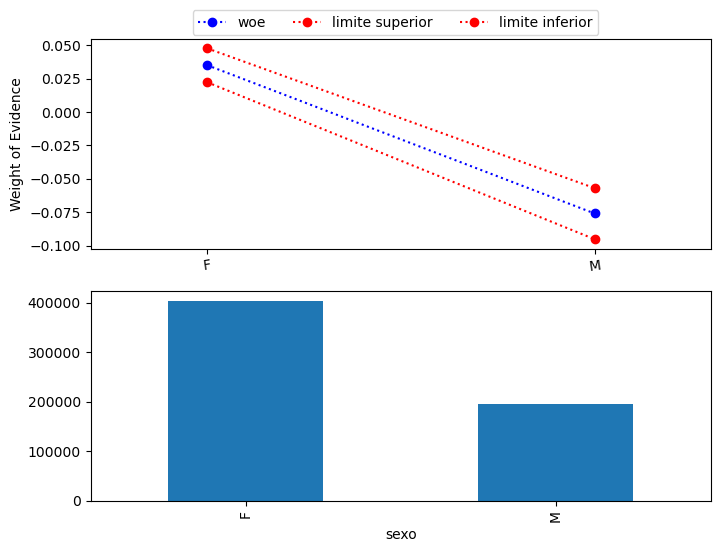

In [28]:
biv_discreta('sexo', df_train);

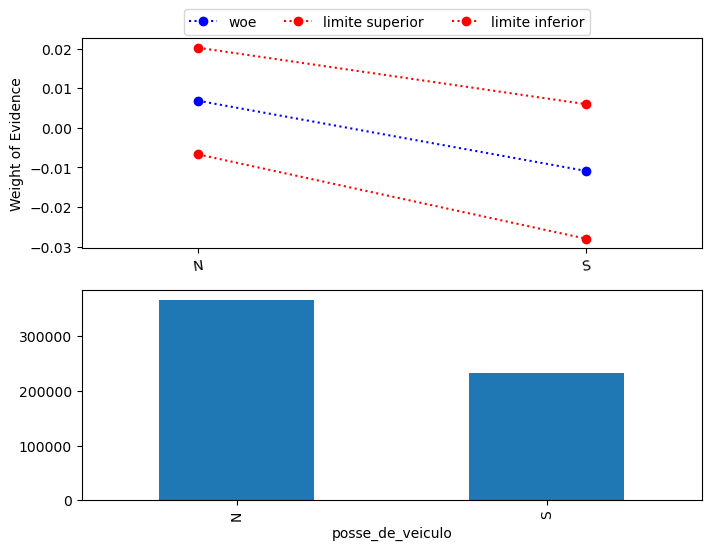

In [29]:
biv_discreta('posse_de_veiculo', df_train);

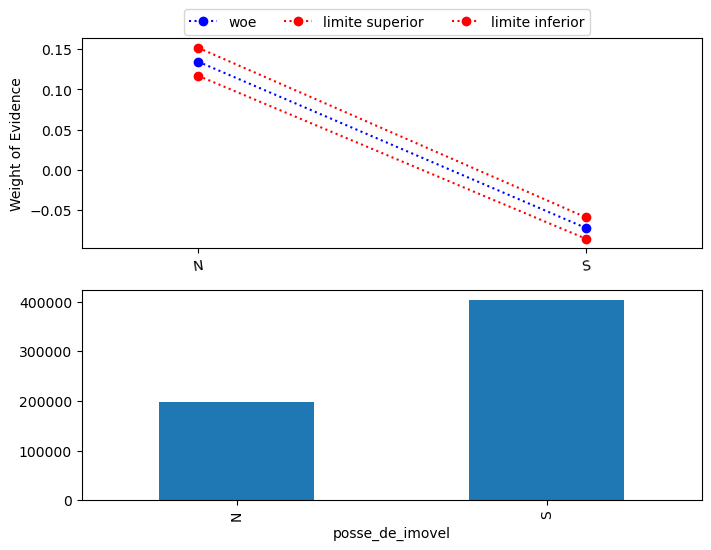

In [30]:
biv_discreta('posse_de_imovel', df_train);

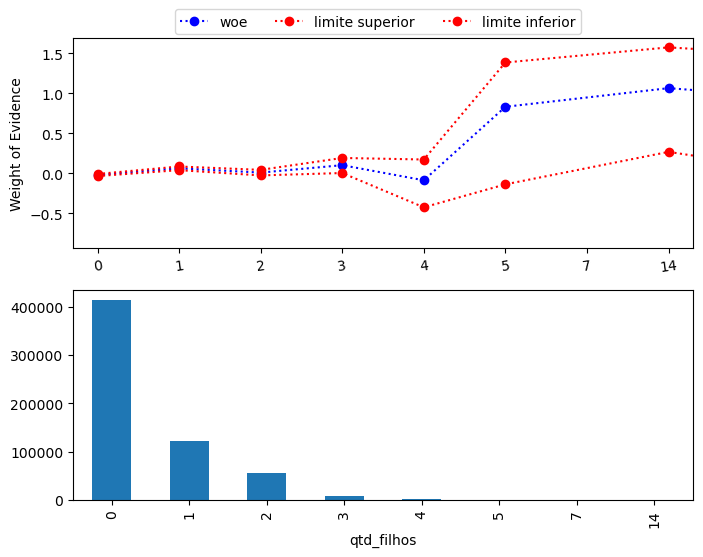

In [31]:
biv_discreta('qtd_filhos', df_train);

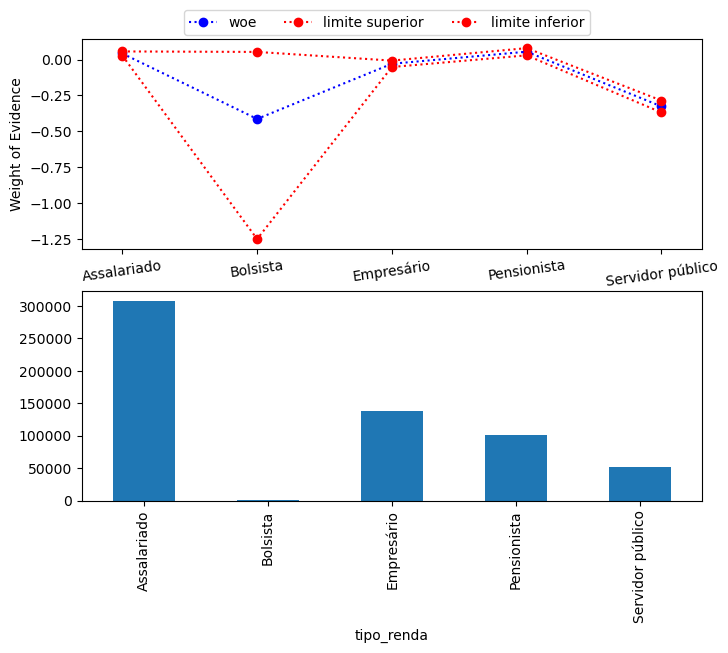

In [32]:
biv_discreta('tipo_renda', df_train);

0.009634301334170859

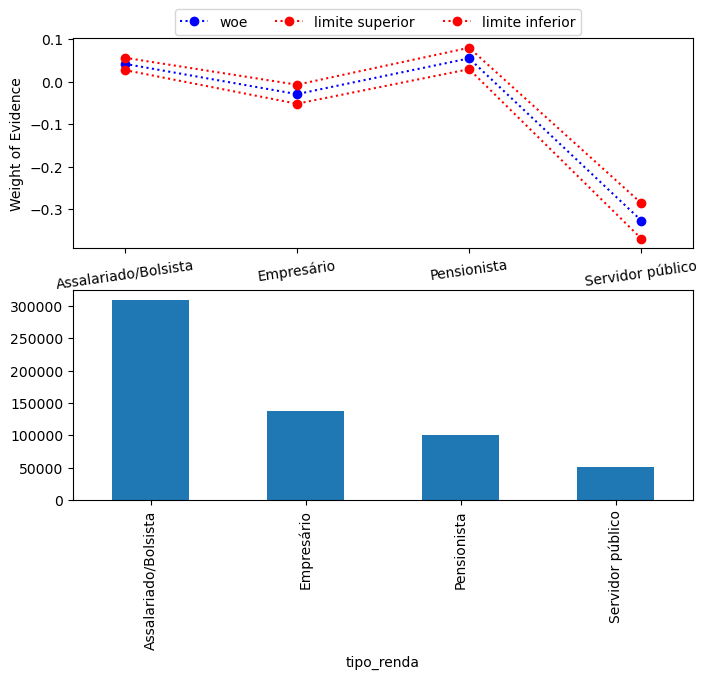

In [33]:
# Agrupando as classes da variável educacao

df_train.tipo_renda.replace({'Assalariado':'Assalariado/Bolsista', 
                      'Bolsista':'Assalariado/Bolsista',
                     }, inplace=True)

biv_discreta('tipo_renda', df_train);
IV(df_train.tipo_renda, df_train.mau)

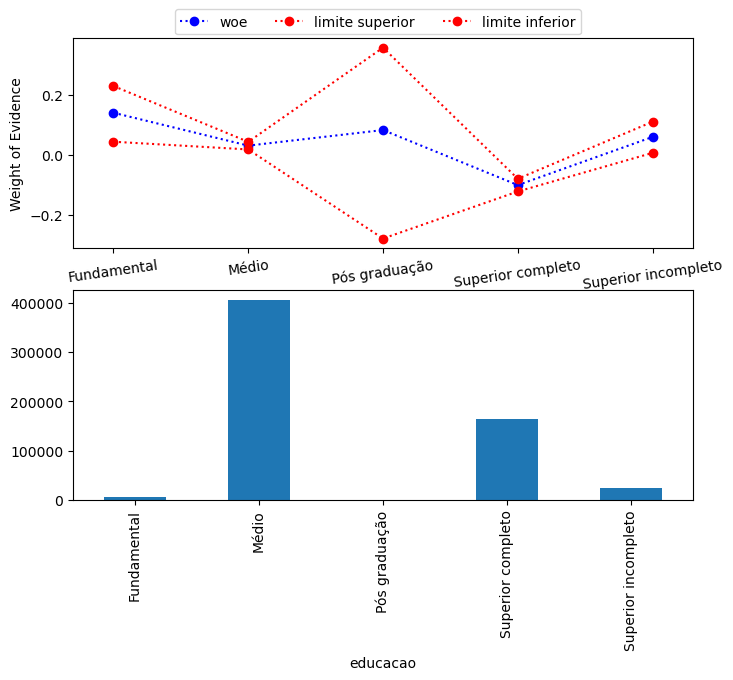

In [34]:
biv_discreta('educacao', df_train);

0.0034801108923340892

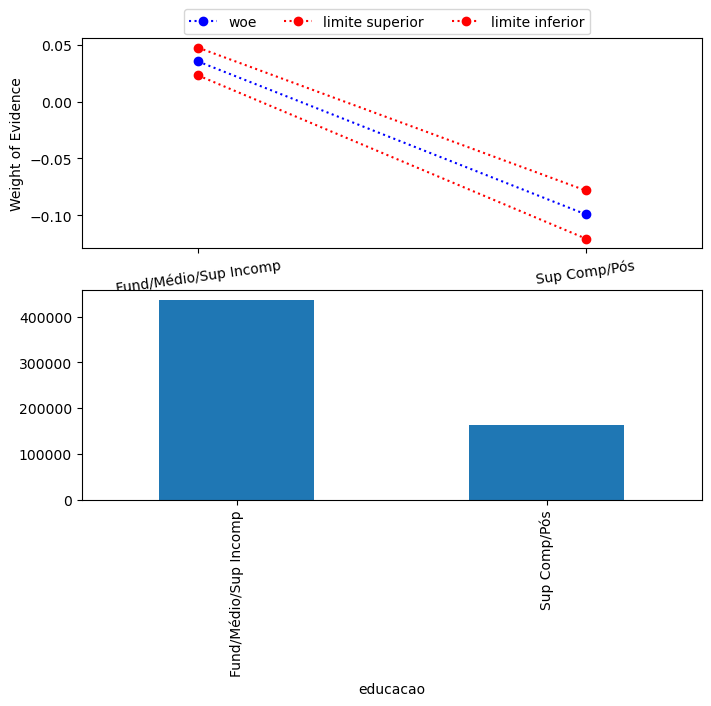

In [35]:
# Agrupando as classes da variável educacao

df_train.educacao.replace({'Fundamental':'Fund/Médio/Sup Incomp', 
                      'Médio':'Fund/Médio/Sup Incomp',
                      'Superior incompleto':'Fund/Médio/Sup Incomp',
                      'Superior completo': 'Sup Comp/Pós',
                      'Pós graduação': 'Sup Comp/Pós'
                     }, inplace=True)

biv_discreta('educacao', df_train);
IV(df_train.educacao, df_train.mau)

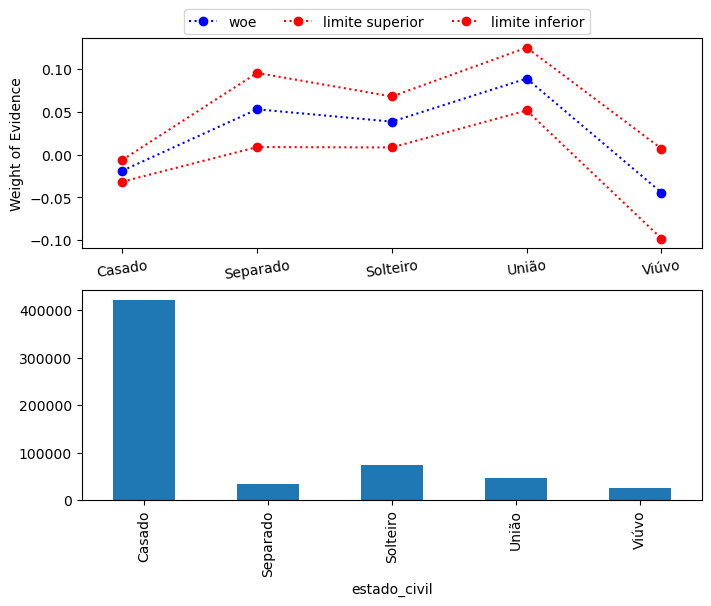

In [36]:
biv_discreta('estado_civil', df_train);

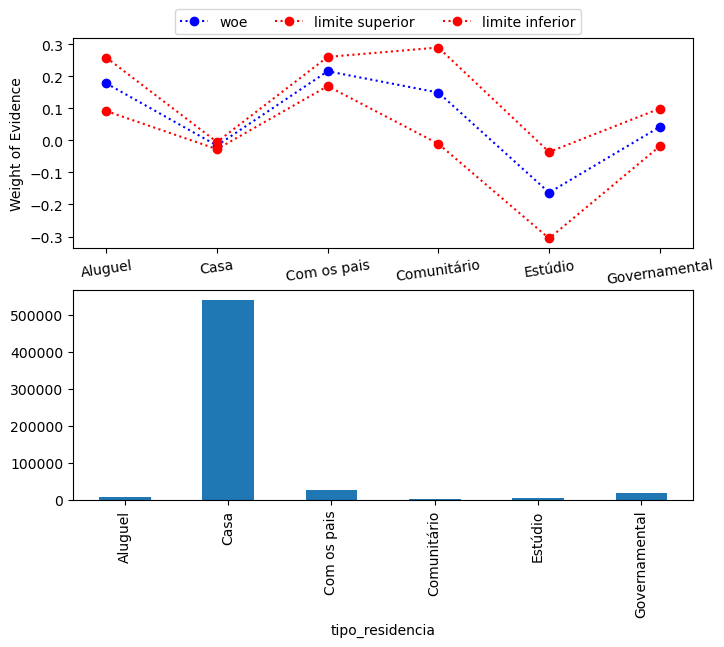

In [37]:
biv_discreta('tipo_residencia', df_train);

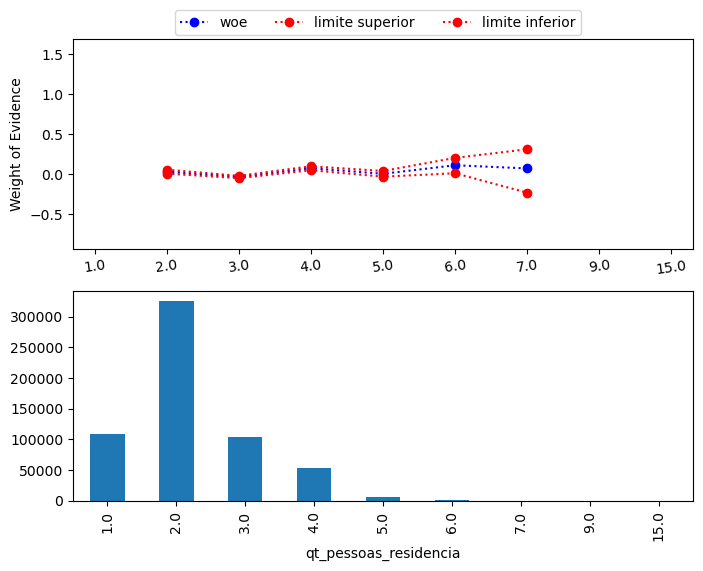

In [38]:
biv_discreta('qt_pessoas_residencia', df_train);

<b>Comentário:</b> Descobrimos zeros estruturais apenas na variável *qt_pessoas_residencia*, utilizando a informação obtida no gráfico bivariado da variável *mau* percebemos que a proporção de inadimplentes não aumenta ou diminui proporcionalmente com a variável *qt_pessoas_residencia*, então ao invés de tratar os zeros estruturais, apenas removerei esta variável do modelo.

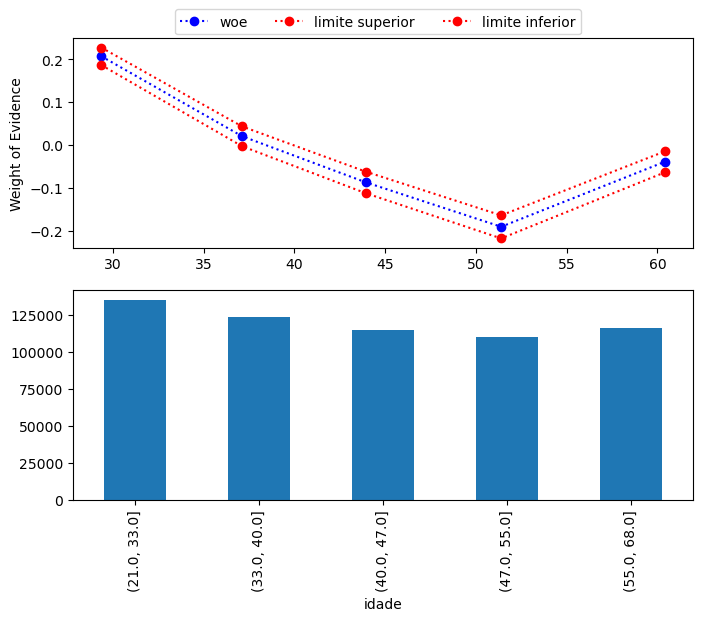

In [39]:
biv_continua('idade', 5, df_train)

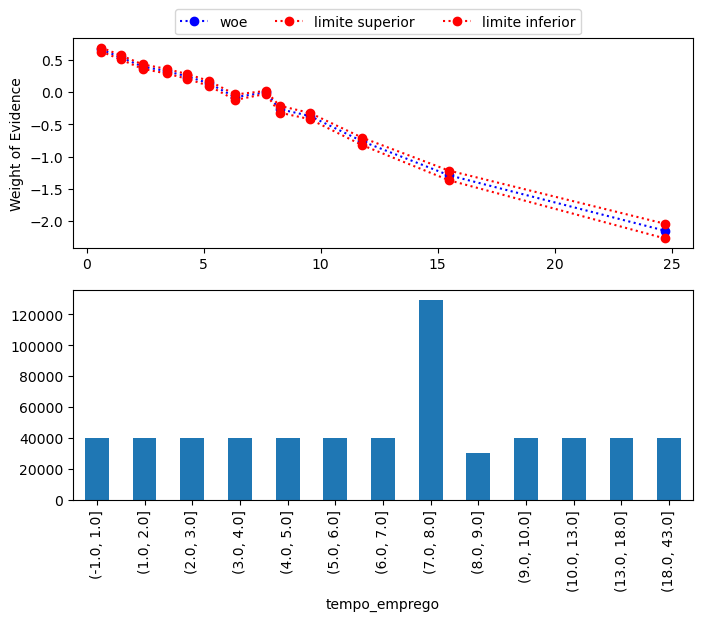

In [40]:
biv_continua('tempo_emprego', 15, df_train)

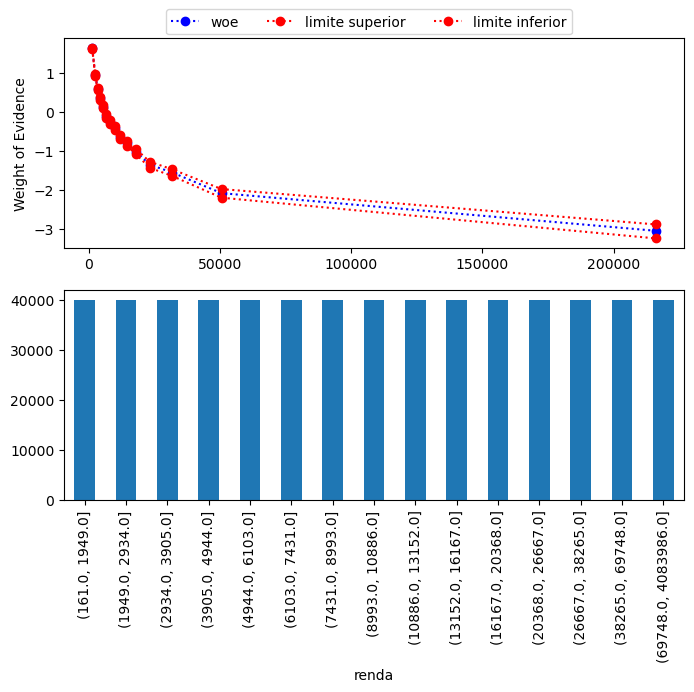

In [41]:
biv_continua('renda', 15, df_train)

* Criando o modelo.

In [42]:
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + 
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego +
    renda
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599979
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2488e+05
Date:                Tue, 25 Oct 2022   Deviance:                   2.4965e+05
Time:                        19:58:11   Pearson chi2:                 1.57e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04260
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.4189      0.053    -26.825      0.000      -1.523      -1.315
sexo[T.M]                           -0.1255      0.013     -9.567      0.000      -0.151      -0.100
posse_de_veiculo[T.S]                0.0313      0.012      2.529      0.011       0.007       0.056
posse_de_imovel[T.S]                -0.0847      0.012     -7.178      0.000      -0.108      -0.062
tipo_renda[T.Empresário]            -0.0545      0.014     -3.900      0.000      -0.082      -0.027
tipo_renda[T.Pensionista]           -0.0411      0.020     -2.032      0.042      -0.081      -0.001
tipo_renda[T.Servidor público]      -0.0330      0.023     -1.421      0.155      -0.079       0.013
educacao[T.Sup Comp/Pós]            -0.0566      0.013     -4.326      0.000      -0.082      -0.031
estado_civil[T.Separado]             0.0374      0.024      1.574      0.116      -0.009       0.084
estado_civil[T.Solteiro]             0.0054      0.017      0.311      0.756      -0.029       0.039
estado_civil[T.União]                0.0472      0.020      2.322      0.020       0.007       0.087
estado_civil[T.Viúvo]               -0.0346      0.029     -1.192      0.233      -0.092       0.022
tipo_residencia[T.Casa]             -0.0879      0.044     -1.995      0.046      -0.174      -0.002
tipo_residencia[T.Com os pais]      -0.0731      0.050     -1.475      0.140      -0.170       0.024
tipo_residencia[T.Comunitário]      -0.1403      0.089     -1.572      0.116      -0.315       0.035
tipo_residencia[T.Estúdio]          -0.0327      0.082     -0.397      0.691      -0.194       0.129
tipo_residencia[T.Governamental]    -0.0834      0.053     -1.565      0.118      -0.188       0.021
qtd_filhos                           0.0036      0.008      0.448      0.654      -0.012       0.019
idade                                0.0003      0.001      0.394      0.693      -0.001       0.002
tempo_emprego                       -0.0236      0.002    -13.100      0.000      -0.027      -0.020
renda                               -0.0001   1.09e-06    -93.691      0.000      -0.000   -9.96e-05
====================================================================================================
"""

In [43]:
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + renda
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2490e+05
Date:                Tue, 25 Oct 2022   Deviance:                   2.4969e+05
Time:                        19:58:26   Pearson chi2:                 1.59e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04253
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4931      0.014   -107.439      0.000      -1.520      -1.466
sexo[T.M]                   -0.1072      0.012     -8.926      0.000      -0.131      -0.084
posse_de_imovel[T.S]        -0.0897      0.011     -7.845      0.000      -0.112      -0.067
educacao[T.Sup Comp/Pós]    -0.0569      0.013     -4.477      0.000      -0.082      -0.032
tempo_emprego               -0.0245      0.002    -14.616      0.000      -0.028      -0.021
renda                       -0.0001   1.08e-06    -94.209      0.000      -0.000   -9.96e-05
============================================================================================
"""

In [44]:
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + renda
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2490e+05
Date:                Tue, 25 Oct 2022   Deviance:                   2.4969e+05
Time:                        19:58:41   Pearson chi2:                 1.59e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04253
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4931      0.014   -107.439      0.000      -1.520      -1.466
sexo[T.M]                   -0.1072      0.012     -8.926      0.000      -0.131      -0.084
posse_de_imovel[T.S]        -0.0897      0.011     -7.845      0.000      -0.112      -0.067
educacao[T.Sup Comp/Pós]    -0.0569      0.013     -4.477      0.000      -0.082      -0.032
tempo_emprego               -0.0245      0.002    -14.616      0.000      -0.028      -0.021
renda                       -0.0001   1.08e-06    -94.209      0.000      -0.000   -9.96e-05
============================================================================================
"""

* Geralmente em modelos que envolvem renda o log da renda tende a favorecer o modelo, irei testar.

In [47]:
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + np.log(renda)
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2027e+05
Date:                Tue, 25 Oct 2022   Deviance:                   2.4055e+05
Time:                        20:04:36   Pearson chi2:                 5.97e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05720
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.9194      0.051    115.829      0.000       5.819       6.020
sexo[T.M]                   -0.0018      0.012     -0.149      0.882      -0.026       0.022
posse_de_imovel[T.S]        -0.0175      0.012     -1.494      0.135      -0.040       0.005
educacao[T.Sup Comp/Pós]    -0.0056      0.013     -0.430      0.667      -0.031       0.020
tempo_emprego               -0.0010      0.002     -0.610      0.542      -0.004       0.002
np.log(renda)               -0.9881      0.007   -149.914      0.000      -1.001      -0.975
============================================================================================
"""

In [48]:
formula = '''
    mau ~ np.log(renda)
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2028e+05
Date:                Tue, 25 Oct 2022   Deviance:                   2.4055e+05
Time:                        20:04:39   Pearson chi2:                 5.97e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05719
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.9239      0.049    121.382      0.000       5.828       6.020
np.log(renda)    -0.9908      0.006   -169.858      0.000      -1.002      -0.979
=================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [49]:
df_train['score'] = rl.predict(df_train)

# Acurácia
acc = metrics.accuracy_score(df_train.mau, df_train.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_train.mau, df_train.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_train.loc[df_train.mau == 1, 'score'], df_train.loc[df_train.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 71.9% 
AUC: 77.0% 
GINI: 54.0%
KS: 39.9%


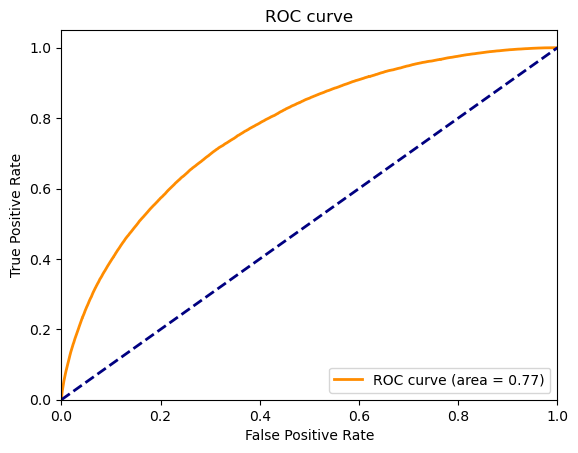

In [50]:
fpr, tpr, thresholds = metrics.roc_curve(df_train['mau'], df_train['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_train['mau'], df_train['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

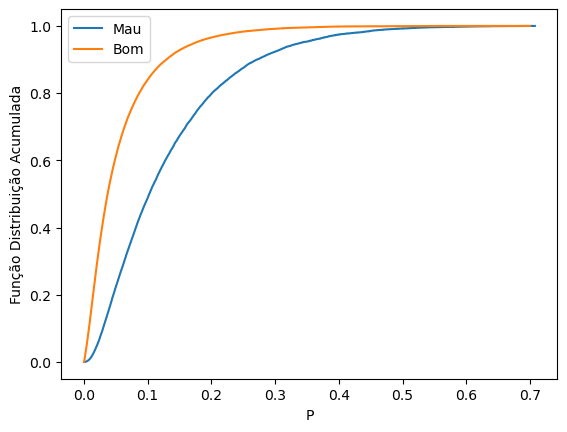

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df_train.loc[df_train['mau']==1,'score']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Mau')

score_pop2 = df_train.loc[df_train['mau']!=1,'score']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Bom')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')

- Comentário: Conseguimos um bom valor de acurácia, a curva ROC ficou com uma área maior do que 0.5 o que já é bom, apesar que um valor próximo de 0.75 seria algo considerado mediano, o gráfico da função distribuição acumulada não está excelente, mas um KS de quase 40% não é de todo ruim.


- Base de teste *out of time*.

In [52]:
df_test['tempo_emprego'].fillna(value=df_test['tempo_emprego'].mean(), inplace=True)


In [53]:
df_test.educacao.replace({'Fundamental':'Fund/Médio/Sup Incomp', 
                      'Médio':'Fund/Médio/Sup Incomp',
                      'Superior incompleto':'Fund/Médio/Sup Incomp',
                      'Superior completo': 'Sup Comp/Pós',
                      'Pós graduação': 'Sup Comp/Pós'
                     }, inplace=True)

In [54]:
df_test['score'] = rl.predict(df_test)

# Acurácia
acc = metrics.accuracy_score(df_test.mau, df_test.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_test.mau, df_test.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_test.loc[df_test.mau == 1, 'score'], df_test.loc[df_test.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 39.3% 
AUC: 73.9% 
GINI: 47.8%
KS: 34.7%


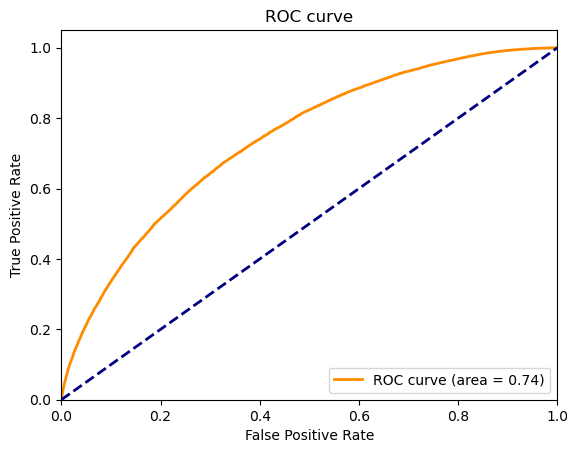

In [55]:
fpr, tpr, thresholds = metrics.roc_curve(df_test['mau'], df_test['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_test['mau'], df_test['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

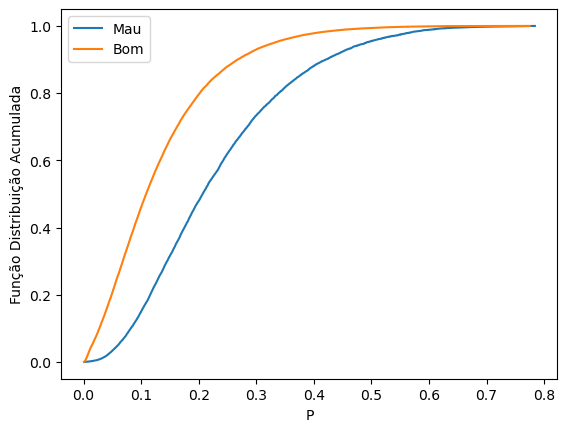

In [56]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df_test.loc[df_test['mau']==1,'score']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Mau')

score_pop2 = df_test.loc[df_test['mau']!=1,'score']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Bom')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')

<b>Comentário:</b> Apesar de percebemos uma queda grande no valor da acurácia na base de testes os indicadores AUC, GINI e KS pouco se alteraram, o modelo continua robusto.